# Unpacking Function Vectors

**Jonathan Keane | November 16, 2025**

To understand more of the nuances behind what function vectors are and how they are computed, I wanted to do some extra logging and documenting of how this works in practice before proceeding on to more experiments.

If you have not read the paper associated with this work, a **function vector** is a vector that can be inserted into the residual stream of a transformer in place of a certain token's internal embedding at any layer such that it can "apply an operation" in arbitrary contexts. So for example, if given the sentence `left :` with no context, you could replace the `:`'s internal embedding with a function vector to make the model produce an output like `right` (antonym function vector) or `izquierda` (translation function vector). This is done through extracting information from transformer internal embeddings when a transformer is in the process of doing in-context learning (ICL) for the same task, which will be described further below.

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os, re, json
import torch, numpy as np
from tqdm import tqdm
import pandas as pd
from scipy.interpolate import griddata

import sys
sys.path.append('..')
torch.set_grad_enabled(False)

from src.utils.extract_utils import get_mean_head_activations, compute_universal_function_vector
from src.utils.intervention_utils import fv_intervention_natural_text, function_vector_intervention
from src.utils.model_utils import load_gpt_model_and_tokenizer
from src.utils.prompt_utils import load_dataset, word_pairs_to_prompt_data, create_prompt
from src.utils.eval_utils import decode_to_vocab, sentence_eval

## Load model & tokenizer

In [3]:
model_name = 'EleutherAI/gpt-j-6b'
model, tokenizer, model_config = load_gpt_model_and_tokenizer(model_name)
EDIT_LAYER = 9

Loading:  EleutherAI/gpt-j-6b


Some weights of the model checkpoint at EleutherAI/gpt-j-6b were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.20.attn.bi

## Dataset

For a series of different tasks, there are just pairs of input text and their corresponding output text. In the example below, we are working with antonym pairs.

In [4]:
dataset = load_dataset('antonym', seed=0)
print(json.dumps(dataset['train'][:4], indent=2))

{
  "input": [
    "limitless",
    "wake",
    "elevate",
    "push"
  ],
  "output": [
    "limited",
    "sleep",
    "depress",
    "pull"
  ]
}


# Compute Task-Conditioned Mean Activations

To create a function vector, you need to have activations of tokens from places where in-context learning (ICL) was occurring across ***all*** attention heads in the transformer (although only some will be used in practice). To do this, for a series of trials, a set of random samples from a task's corresponding dataset will be used to get activations resulting from all attention heads in the transformer. This will be used to generate activations from all attention heads in the transformers for all tokens in all trial prompts, resulting in a matrix of activations of shape $(n\_trials, n\_layers, n\_heads, n\_tokens, d\_head)$, which will then be averaged along the trial dimension to get the average in-context learning activations that are generated from samples in this task.

***Comment:*** This is a really interesting paradigm because it seems to almost create a "training process" while working with a trained LLM to start (sort of a way of doing model distillation). 

In [5]:
mean_activations = get_mean_head_activations(dataset, model, model_config, tokenizer, n_icl_examples=10, N_TRIALS=100)

In [6]:
from src.utils.prompt_utils import get_dummy_token_labels
from src.utils.extract_utils import gather_attn_activations
from IPython.display import display, Markdown

def get_mean_head_activations_unpacked(dataset, model, model_config, tokenizer, n_icl_examples = 10, N_TRIALS = 100, shuffle_labels=False, prefixes=None, separators=None, filter_set=None):
    def split_activations_by_head(activations, model_config):
        new_shape = activations.size()[:-1] + (model_config['n_heads'], model_config['resid_dim']//model_config['n_heads']) # split by head: + (n_attn_heads, hidden_size/n_attn_heads)
        activations = activations.view(*new_shape)  # (batch_size, n_tokens, n_heads, head_hidden_dim)
        return activations

    n_test_examples = 1
    if prefixes is not None and separators is not None:
        dummy_labels = get_dummy_token_labels(n_icl_examples, tokenizer=tokenizer, prefixes=prefixes, separators=separators, model_config=model_config)
    else:
        dummy_labels = get_dummy_token_labels(n_icl_examples, tokenizer=tokenizer, model_config=model_config)
    activation_storage = torch.zeros(N_TRIALS, model_config['n_layers'], model_config['n_heads'], len(dummy_labels), model_config['resid_dim']//model_config['n_heads'])

    if filter_set is None:
        filter_set = np.arange(len(dataset['valid']))

    # If the model already prepends a bos token by default, we don't want to add one
    prepend_bos =  False if model_config['prepend_bos'] else True

    word_pair_info = []
    for n in range(N_TRIALS):
        word_pairs = dataset['train'][np.random.choice(len(dataset['train']),n_icl_examples, replace=False)]
        word_pairs_test = dataset['valid'][np.random.choice(filter_set,n_test_examples, replace=False)]
        if prefixes is not None and separators is not None:
            prompt_data = word_pairs_to_prompt_data(word_pairs, query_target_pair=word_pairs_test, prepend_bos_token=prepend_bos, 
                                                    shuffle_labels=shuffle_labels, prefixes=prefixes, separators=separators)
        else:
            prompt_data = word_pairs_to_prompt_data(word_pairs, query_target_pair=word_pairs_test, prepend_bos_token=prepend_bos, shuffle_labels=shuffle_labels)
        word_pair_info.append({'word_pairs': word_pairs, 'word_pairs_test': word_pairs_test})
        activations_td,idx_map,idx_avg = gather_attn_activations(prompt_data=prompt_data, 
                                                            layers = model_config['attn_hook_names'], 
                                                            dummy_labels=dummy_labels, 
                                                            model=model, 
                                                            tokenizer=tokenizer, 
                                                            model_config=model_config)

        stack_initial = torch.vstack([split_activations_by_head(activations_td[layer].input, model_config) for layer in model_config['attn_hook_names']]).permute(0,2,1,3)
        stack_filtered = stack_initial[:,:,list(idx_map.keys())]
        for (i,j) in idx_avg.values():
            stack_filtered[:,:,idx_map[i]] = stack_initial[:,:,i:j+1].mean(axis=2) # Average activations of multi-token words across all its tokens
        
        activation_storage[n] = stack_filtered

    mean_activations = activation_storage.mean(dim=0) # averaging over trials (not tokens => 97 represents n_tokens)
    return mean_activations, word_pair_info

mean_activations, word_pair_info = get_mean_head_activations_unpacked(dataset, model, model_config, tokenizer)

def tabulate(data, headers):
    table = "| " + " | ".join(headers) + " |\n"
    table += "| " + " | ".join(["---"] * len(headers)) + " |\n"
    for row in data[1:]:
        table += "| " + " | ".join(row) + " |\n"
    return table

n_samples_display = 2
table_data_headers = []
table_data = []
for sample_idx in range(n_samples_display):
    sample_data = word_pair_info[sample_idx]
    sample_table_data = [
        [
            sample_data["word_pairs"]["input"][i], 
            sample_data["word_pairs"]["output"][i]
        ] 
        for i in range(len(sample_data["word_pairs"]["input"]))
    ]
    sample_table_data.append([
        f'**Query**: {sample_data["word_pairs_test"]["input"][0]}', 
        f'**Target**: {sample_data["word_pairs_test"]["output"][0]}',
    ])
    if len(table_data) == 0:
        table_data = sample_table_data
    else:
        for i in range(len(sample_table_data)):
            table_data[i].extend(sample_table_data[i])
    table_data_headers.extend([f"Trial {sample_idx+1}: Input", f"Trial {sample_idx+1}: Output"])

display(Markdown("### In-Context Examples"))
display(Markdown(tabulate(table_data, table_data_headers)))
print("Mean Activations Shape:", mean_activations.shape) # (n_layers, n_heads, n_tokens, head_hidden_dim)

### In-Context Examples

| Trial 1: Input | Trial 1: Output | Trial 2: Input | Trial 2: Output |
| --- | --- | --- | --- |
| abundance | scarcity | multinational | local |
| sister | brother | bent | straight |
| server | client | unnecessary | necessary |
| blend | stand out | exaggeration | understatement |
| imaginary | real | respect | disrespect |
| many | few | bright | dim |
| unauthorized | authorized | disinfect | contaminate |
| connected | disconnected | mortality | immortality |
| avert | embrace | noticeable | unnoticeable |
| **Query**: applicable | **Target**: inapplicable | **Query**: change | **Target**: stay the same |


Mean Activations Shape: torch.Size([28, 16, 97, 256])


## Compute Function Vector (FV)

While the previous step looked to create the activations for every attention head in every layer for every token, part of the work done in this paper was the process of building function vectors using activations from only the attention heads that are most likely to contribute this more general capability of in-context learning.

To filter down to the most important heads that should be used for building the function vector, you first just want to look at the attention head output activations associated to the final token of an in-context learning prompt (such as the `:` in the example discussed in the intro). Then, you choose the $n$ attention heads that have the highest impact on in-context learning related tasks.

**How do you evaluate high impact on in-context learning?**

The authors propose a metric called average indirect effect (AIE). This metric works by taking attention head activations for a prompt with random relationships being defined as a baseline for performance. Then, by replacing single attention heads with the average attention head activation observed for the in-context learning samples, an estimate for how important a head is can be made.

***Comment:*** The authors hard code these weights in the implementations of the demo because it seems that similar heads are activate across different tasks. This relates similarly to some interpretability work that Anthropic has done that looks at induction heads as heads that are better in repeating similar phrases during in-context learning.

- *The authors did do some further analysis of this in their appendix and found that while there is some overlap between the heads they identified as top candidates for making function vectors and heads that show signs of being induction heads, they are not completely overlapping (which could mean that there could be future work in distinguishing these different kinds of heads well equipped for in-context learning).* 

In [7]:
FV, top_heads = compute_universal_function_vector(mean_activations, model, model_config, n_top_heads=10)
print("Function Vector Shape:", FV.shape) # (n_layers, n_heads, head_hidden_dim)
print("Top Heads:", top_heads)

Function Vector Shape: torch.Size([1, 4096])
Top Heads: [(15, 5, 0.0587), (9, 14, 0.0584), (12, 10, 0.0526), (8, 1, 0.0445), (11, 0, 0.0445), (13, 13, 0.019), (8, 0, 0.0184), (14, 9, 0.016), (9, 2, 0.0127), (24, 6, 0.0113)]


## Prompt Creation - ICL, Shuffled-Label, Zero-Shot, and Natural Text

In [8]:
# Sample ICL example pairs, and a test word
dataset = load_dataset('antonym')
word_pairs = dataset['train'][:5]
test_pair = dataset['test'][21]

prompt_data = word_pairs_to_prompt_data(word_pairs, query_target_pair=test_pair, prepend_bos_token=True)
sentence = create_prompt(prompt_data)
print("ICL prompt:\n", repr(sentence), '\n\n')

shuffled_prompt_data = word_pairs_to_prompt_data(word_pairs, query_target_pair=test_pair, prepend_bos_token=True, shuffle_labels=True)
shuffled_sentence = create_prompt(shuffled_prompt_data)
print("Shuffled ICL Prompt:\n", repr(shuffled_sentence), '\n\n')

zeroshot_prompt_data = word_pairs_to_prompt_data({'input':[], 'output':[]}, query_target_pair=test_pair, prepend_bos_token=True, shuffle_labels=True)
zeroshot_sentence = create_prompt(zeroshot_prompt_data)
print("Zero-Shot Prompt:\n", repr(zeroshot_sentence))

ICL prompt:
 '<|endoftext|>Q: hardware\nA: software\n\nQ: fascism\nA: democracy\n\nQ: incompatible\nA: compatible\n\nQ: illness\nA: health\n\nQ: notice\nA: ignore\n\nQ: increase\nA:' 


Shuffled ICL Prompt:
 '<|endoftext|>Q: hardware\nA: democracy\n\nQ: fascism\nA: software\n\nQ: incompatible\nA: ignore\n\nQ: illness\nA: compatible\n\nQ: notice\nA: health\n\nQ: increase\nA:' 


Zero-Shot Prompt:
 '<|endoftext|>Q: increase\nA:'


## Evaluation

### Clean ICL Prompt

In [9]:
# Check model's ICL answer
clean_logits = sentence_eval(sentence, [test_pair['output']], model, tokenizer, compute_nll=False)

print("Input Sentence:", repr(sentence), '\n')
print(f"Input Query: {repr(test_pair['input'])}, Target: {repr(test_pair['output'])}\n")
print("ICL Prompt Top K Vocab Probs:\n", decode_to_vocab(clean_logits, tokenizer, k=5), '\n')

Input Sentence: '<|endoftext|>Q: hardware\nA: software\n\nQ: fascism\nA: democracy\n\nQ: incompatible\nA: compatible\n\nQ: illness\nA: health\n\nQ: notice\nA: ignore\n\nQ: increase\nA:' 

Input Query: 'increase', Target: 'decrease'

ICL Prompt Top K Vocab Probs:
 [(' decrease', 0.73675), (' reduce', 0.07769), (' increase', 0.03435), (' decline', 0.01574), (' decreased', 0.01037)] 



### Corrupted ICL Prompt

In [10]:
# Perform an intervention on the shuffled setting
clean_logits, interv_logits = function_vector_intervention(shuffled_sentence, [test_pair['output']], EDIT_LAYER, FV, model, model_config, tokenizer)

print("Input Sentence:", repr(shuffled_sentence), '\n')
print(f"Input Query: {repr(test_pair['input'])}, Target: {repr(test_pair['output'])}\n")
print("Few-Shot-Shuffled Prompt Top K Vocab Probs:\n", decode_to_vocab(clean_logits, tokenizer, k=5), '\n')
print("Shuffled Prompt+FV Top K Vocab Probs:\n", decode_to_vocab(interv_logits, tokenizer, k=5))

Input Sentence: '<|endoftext|>Q: hardware\nA: democracy\n\nQ: fascism\nA: software\n\nQ: incompatible\nA: ignore\n\nQ: illness\nA: compatible\n\nQ: notice\nA: health\n\nQ: increase\nA:' 

Input Query: 'increase', Target: 'decrease'

Few-Shot-Shuffled Prompt Top K Vocab Probs:
 [(' notice', 0.04294), (' decrease', 0.02164), (' increase', 0.01897), (' compatible', 0.01748), (' software', 0.01739)] 

Shuffled Prompt+FV Top K Vocab Probs:
 [(' decrease', 0.48979), (' reduce', 0.03664), (' decline', 0.02742), (' increase', 0.01453), (' notice', 0.01417)]


### Zero-Shot Prompt

In [11]:
# Intervention on the zero-shot prompt
clean_logits, interv_logits = function_vector_intervention(zeroshot_sentence, [test_pair['output']], EDIT_LAYER, FV, model, model_config, tokenizer)

print("Input Sentence:", repr(zeroshot_sentence), '\n')
print(f"Input Query: {repr(test_pair['input'])}, Target: {repr(test_pair['output'])}\n")
print("Zero-Shot Top K Vocab Probs:\n", decode_to_vocab(clean_logits, tokenizer, k=5), '\n')
print("Zero-Shot+FV Vocab Top K Vocab Probs:\n", decode_to_vocab(interv_logits, tokenizer, k=5))

Input Sentence: '<|endoftext|>Q: increase\nA:' 

Input Query: 'increase', Target: 'decrease'

Zero-Shot Top K Vocab Probs:
 [(' increase', 0.14925), (' yes', 0.02272), (' I', 0.02189), (' the', 0.0212), (' 1', 0.01418)] 

Zero-Shot+FV Vocab Top K Vocab Probs:
 [(' decrease', 0.27786), (' increase', 0.18013), (' reduce', 0.03543), (' improve', 0.00936), ('\n', 0.00577)]


### Natural Text Prompt

In [12]:
sentence = f"The word \"{test_pair['input']}\" means"
co, io = fv_intervention_natural_text(sentence, EDIT_LAYER, FV, model, model_config, tokenizer, max_new_tokens=10)


print("Input Sentence: ", repr(sentence))
print("GPT-J:" , repr(tokenizer.decode(co.squeeze())))
print("GPT-J+FV:", repr(tokenizer.decode(io.squeeze())), '\n')

Input Sentence:  'The word "increase" means'
GPT-J: 'The word "increase" means "to make larger, to enlarge, to expand'
GPT-J+FV: 'The word "increase" means "decrease" in the Bible.\n' 



## Jonny Additions

### Zero-Shot Application to New Q/A Pair

This is cool and all that it remembers to say decrease for this example, but is this an actual "antonym" function vector (this is how I had originally interpreted the paper, but the examples don't show this off). I test with a couple pairs below:

In [13]:
new_test_pair = {'input': 'happy', 'output': 'sad'}
sentence = f"The word \"{new_test_pair['input']}\" means"
co, io = fv_intervention_natural_text(sentence, EDIT_LAYER, FV, model, model_config, tokenizer, max_new_tokens=10)

print("Input Sentence: ", repr(sentence))
print("GPT-J:" , repr(tokenizer.decode(co.squeeze())))
print("GPT-J+FV:", repr(tokenizer.decode(io.squeeze())), '\n')

Input Sentence:  'The word "happy" means'
GPT-J: 'The word "happy" means different things to different people. For some, it'
GPT-J+FV: 'The word "happy" means "sad" in the dictionary.\n\n' 



In [14]:
new_test_pair = {'input': 'yin', 'output': 'yang'}
sentence = f"The word \"{new_test_pair['input']}\" means"
co, io = fv_intervention_natural_text(sentence, EDIT_LAYER, FV, model, model_config, tokenizer, max_new_tokens=10)

print("Input Sentence: ", repr(sentence))
print("GPT-J:" , repr(tokenizer.decode(co.squeeze())))
print("GPT-J+FV:", repr(tokenizer.decode(io.squeeze())), '\n')

Input Sentence:  'The word "yin" means'
GPT-J: 'The word "yin" means "darkness" or "black" in Chinese'
GPT-J+FV: 'The word "yin" means "yang." The word "yin" means' 



# Questions

1. What does the embedding of the original token look like if it does not have as much in-context learning effecting it?
    
    - If you increase/decrease the number of samples, is there a convergence to a single vector that represents opposites? (I feel like the embedding should start pretty spread out if you ablate certain samples that are part of the context and then converge as you get to a more complete set)

2. Is it the embedding of the colon that is changing or is it the tokens around it that are changing in terms of their position?

#### Question 1

1. What does the embedding of the original token look like if it does not have as much in-context learning effecting it?
    
    - If you increase/decrease the number of samples, is there a convergence to a single vector that represents opposites? (I feel like the embedding should start pretty spread out if you ablate certain samples that are part of the context and then converge as you get to a more complete set)

To play with this question, I want to ruse the mean activations that are resulting from `get_mean_head_activations(dataset, model, model_config, tokenizer, n_icl_examples, N_TRIALS)` to use different numbers of `n_icl_examples` for singular trials and using `compute_universal_function_vector(mean_activations, model, model_config, n_top_heads)` to compute the function vector for these. I then want to perform dimensionality reduction to visualize the relationships in this space. I am hypothesizing that as `n_icl_examples` increases, the samples will be more towards the center of the distribution of function vectors since they are more of an averaging of the information in how I currently think about this. 

In [42]:
torch.cuda.empty_cache()

n_icl_samples = [0, 1, 2, 3, 5, 10]
N_TRIALS_PER_SAMPLE = 15

fvs = []
for n_icl in tqdm(n_icl_samples):
    for trial_index in tqdm(range(N_TRIALS_PER_SAMPLE)):
        mean_activations_n, word_pair_info = get_mean_head_activations_unpacked(dataset, model, model_config, tokenizer, n_icl_examples=n_icl, N_TRIALS=1)
        FV_n, _ = compute_universal_function_vector(mean_activations_n, model, model_config, n_top_heads=10)
        fvs.append({
            'n_icl': n_icl,
            'trial_index': trial_index,
            'FV': FV_n,
            'word_pair_info': word_pair_info,
            # 'top_heads': top_heads_n
        })

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:04<00:00,  1.31it/s]


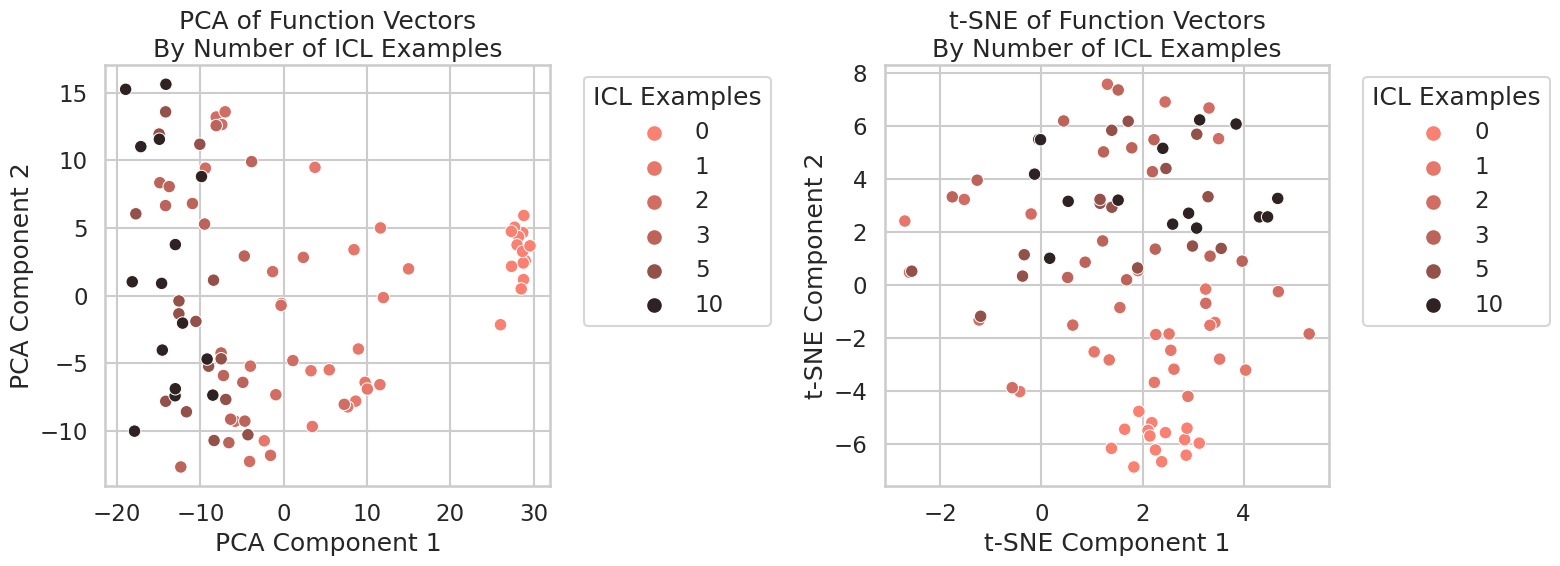

In [56]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

fvs_np = torch.vstack([item['FV'].flatten() for item in fvs]).cpu().detach().numpy()

# PCA
pca = PCA(n_components=2)
fvs_pca = pca.fit_transform(fvs_np)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
fvs_tsne = tsne.fit_transform(fvs_np)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA subplot
sns.scatterplot(
    x=fvs_pca[:, 0], 
    y=fvs_pca[:, 1], 
    hue=[item['n_icl'] for item in fvs], 
    palette='dark:salmon_r', 
    legend='full',
    ax=axes[0]
)
axes[0].set_title('PCA of Function Vectors\nBy Number of ICL Examples')
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')
axes[0].legend(title='ICL Examples', bbox_to_anchor=(1.05, 1), loc='upper left')

# t-SNE subplot
sns.scatterplot(
    x=fvs_tsne[:, 0], 
    y=fvs_tsne[:, 1], 
    hue=[item['n_icl'] for item in fvs], 
    palette='dark:salmon_r', 
    legend='full',
    ax=axes[1]
)
axes[1].set_title('t-SNE of Function Vectors\nBy Number of ICL Examples')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].legend(title='ICL Examples', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Looking at the PCA results, it does not seem that the function vector is necessarily in the center of all the points, but it is interesting to see that there seems to be a concrete direction that is being taken as more ICL samples are involved in building the function vector.

Looking at the t-SNE version, however, you do see a little bit of a centering of the points, but I don't know how to interpret this as much because with how t-SNE works, it is preserving neighbor relationships but maybe not the spatial relationships, so I am weary to accept that as evidence of my hypothesis being proven.

With an addition to this experiment, I tried making zero-shot prompts (no ICL samples in making the function vectors). Interestingly, we see that for those samples, they are much closer together compared to the others in reduced dimensionality spaces. I am guessing this is due to the fact that the heads associatd to in-context learning will not do as much regarding these samples since there is nothing to do in-context learning from.

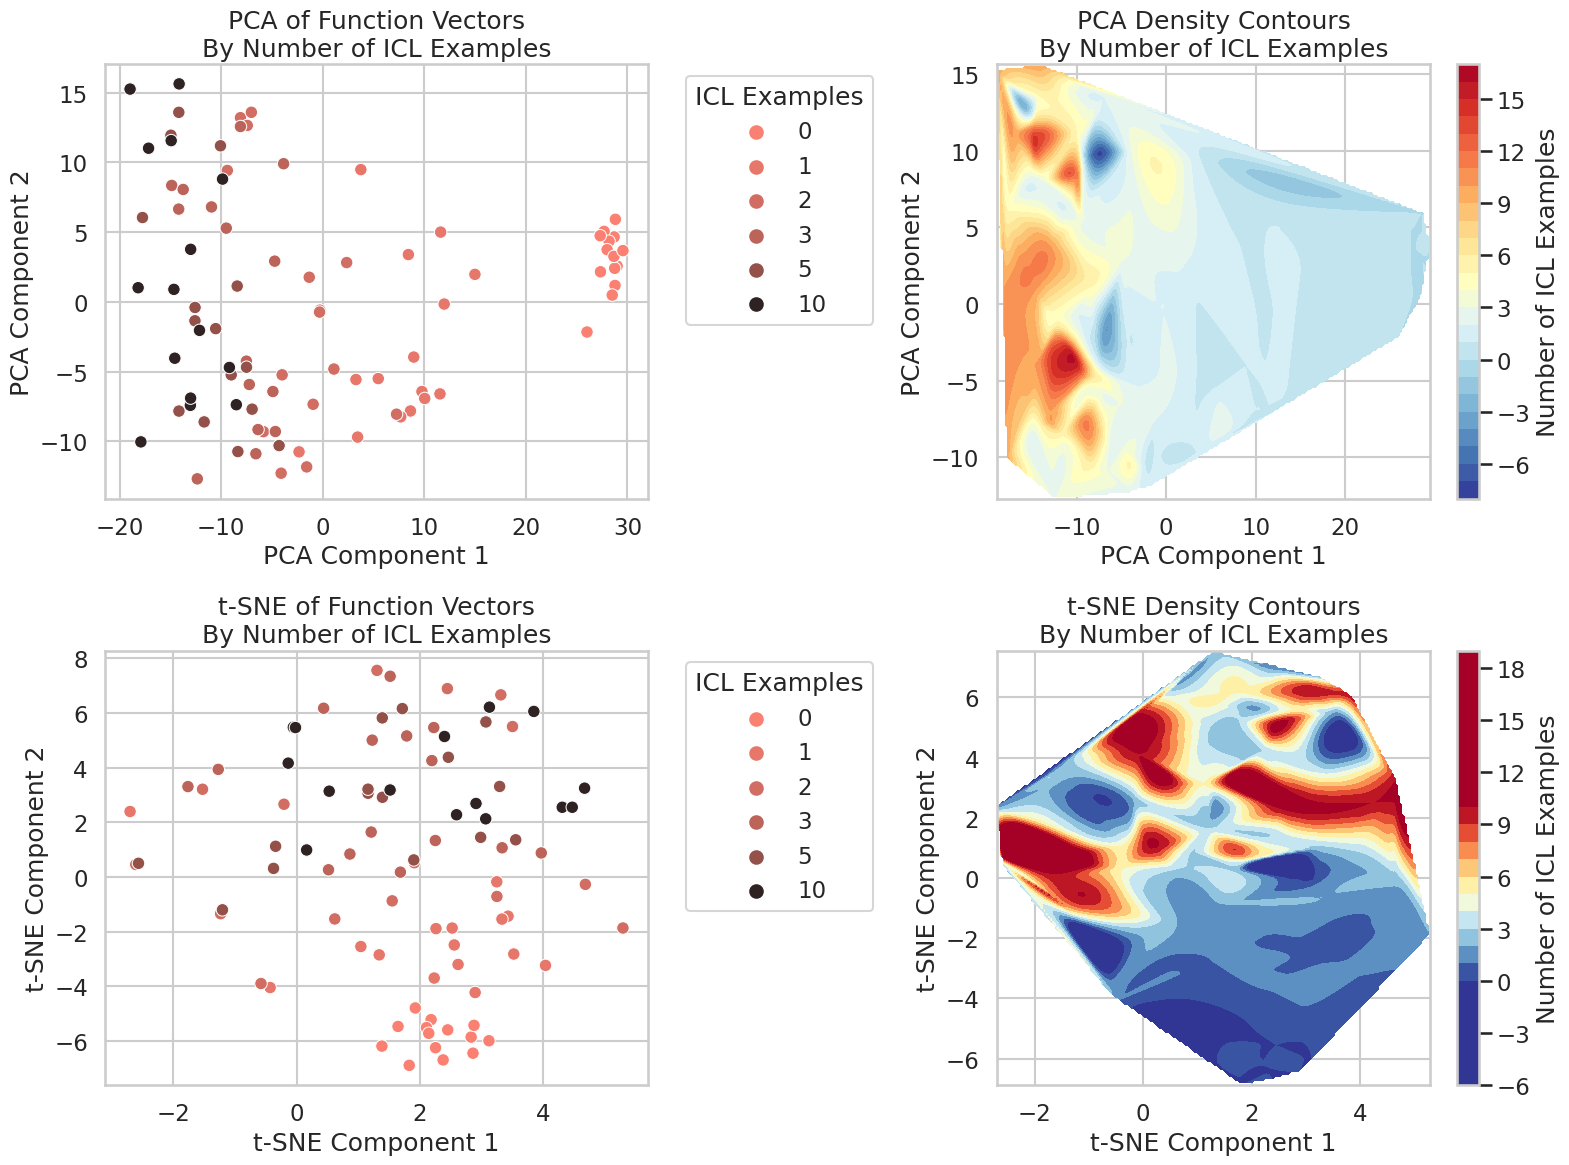

In [47]:
N_LEVELS = 25

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.set_style("whitegrid")
sns.set_context("talk")

# Get min and max values for n_icl
n_icl_values = [item['n_icl'] for item in fvs]
vmin = min(n_icl_values)
vmax = max(n_icl_values)

# PCA scatter plot
sns.scatterplot(
    x=fvs_pca[:, 0], 
    y=fvs_pca[:, 1], 
    hue=n_icl_values, 
    palette='dark:salmon_r', 
    legend='full',
    ax=axes[0, 0]
)
axes[0, 0].set_title('PCA of Function Vectors\nBy Number of ICL Examples')
axes[0, 0].set_xlabel('PCA Component 1')
axes[0, 0].set_ylabel('PCA Component 2')
axes[0, 0].legend(title='ICL Examples', bbox_to_anchor=(1.05, 1), loc='upper left')

# PCA contour plot
x_pca = fvs_pca[:, 0]
y_pca = fvs_pca[:, 1]
z_pca = np.array(n_icl_values)
grid_x_pca, grid_y_pca = np.mgrid[x_pca.min():x_pca.max():200j, y_pca.min():y_pca.max():200j]
grid_z_pca = griddata((x_pca, y_pca), z_pca, (grid_x_pca, grid_y_pca), method='cubic')
contour_pca = axes[0, 1].contourf(grid_x_pca, grid_y_pca, grid_z_pca, levels=N_LEVELS, cmap='RdYlBu_r')
fig.colorbar(contour_pca, ax=axes[0, 1], label="Number of ICL Examples")
axes[0, 1].set_title('PCA Density Contours\nBy Number of ICL Examples')
axes[0, 1].set_xlabel('PCA Component 1')
axes[0, 1].set_ylabel('PCA Component 2')

# t-SNE scatter plot
sns.scatterplot(
    x=fvs_tsne[:, 0], 
    y=fvs_tsne[:, 1], 
    hue=n_icl_values, 
    palette='dark:salmon_r', 
    legend='full',
    ax=axes[1, 0]
)
axes[1, 0].set_title('t-SNE of Function Vectors\nBy Number of ICL Examples')
axes[1, 0].set_xlabel('t-SNE Component 1')
axes[1, 0].set_ylabel('t-SNE Component 2')
axes[1, 0].legend(title='ICL Examples', bbox_to_anchor=(1.05, 1), loc='upper left')

# t-SNE contour plot
x_tsne = fvs_tsne[:, 0]
y_tsne = fvs_tsne[:, 1]
z_tsne = np.array(n_icl_values)
grid_x_tsne, grid_y_tsne = np.mgrid[x_tsne.min():x_tsne.max():200j, y_tsne.min():y_tsne.max():200j]
grid_z_tsne = griddata((x_tsne, y_tsne), z_tsne, (grid_x_tsne, grid_y_tsne), method='cubic')
contour_tsne = axes[1, 1].contourf(grid_x_tsne, grid_y_tsne, grid_z_tsne, levels=N_LEVELS, cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
fig.colorbar(contour_tsne, ax=axes[1, 1], label="Number of ICL Examples")
axes[1, 1].set_title('t-SNE Density Contours\nBy Number of ICL Examples')
axes[1, 1].set_xlabel('t-SNE Component 1')
axes[1, 1].set_ylabel('t-SNE Component 2')

pca_xlim = axes[0, 0].get_xlim()
pca_ylim = axes[0, 0].get_ylim()

plt.tight_layout()
plt.show()


This is cool for building some of my intuition about what the vector space actually looks like during in-context learning. Based on these figures, there seems to be some direction that function vectors are in that is distinctive to the original space that would be created with 0 samples for building in-context learning. In both the t-SNE and PCA visualizations, we see that the resulting function vectors are not resulting in a vector that is in the center of all the samples, but rather this area of more general reasoning is in a different region of the embedding space.

**Question:** Is this "function space" in the embedding space similar across different tasks in term of its position or is different on a per-task basis? If it is similar, it would be interesting to try and find instances that get into this "function space" without looking like in-context learning to see if other things trigger activation in this zone (such of differing formats where ICL is not as easy to be induced by models).

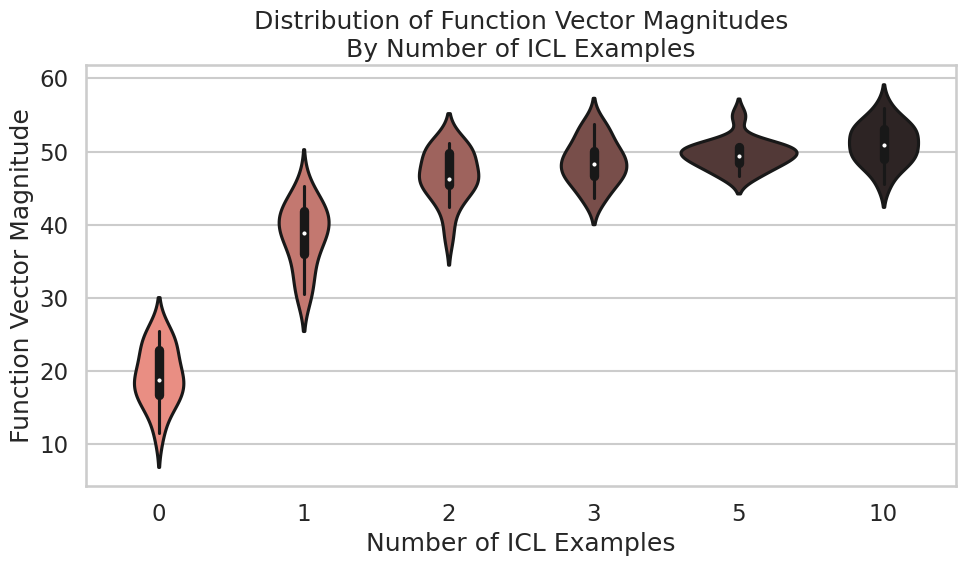

In [54]:
# Calculate magnitudes of function vectors
fv_magnitudes = [torch.norm(item['FV'].flatten()).item() for item in fvs]

# Create violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x=[item['n_icl'] for item in fvs], y=fv_magnitudes, palette='dark:salmon_r')
plt.xlabel('Number of ICL Examples')
plt.ylabel('Function Vector Magnitude')
plt.title('Distribution of Function Vector Magnitudes\nBy Number of ICL Examples')
plt.tight_layout()
plt.show()

The other thing that is alluded to in the above figures is that the vectors start to become bigger in magnitude/more spread out based on the reduced dimension visualizations. We create a visualization of this magnitude increase here for different numbers of ICL examples. This almost seems like a way of indicating model confidence in the task by looking at the vectors. *(This could be interesting to look at in more complex problems because maybe this could be a way to identify an ideal number of samples that are needed in context to describe a task effectively to an LLM)*.

This stretching from `n_icls = 0` to `n_icls = 1` is also interesting because it makes it seem like certain samples move towards a magnitude associated with in-context learning more quickly. We can look at those samples below:

In [52]:
n_icl_1_trials = [item for item in fvs if item['n_icl'] == 1]

table_rows = []
for idx, trial in enumerate(n_icl_1_trials):
    trial_num = trial['trial_index']
    magnitude = torch.norm(trial['FV'].flatten()).item()
    word_pairs = trial['word_pair_info'][0]['word_pairs']
    input_word = word_pairs['input'][0]
    output_word = word_pairs['output'][0]
    table_rows.append([str(trial_num), input_word, output_word, f"{magnitude:.4f}"])
    
table_rows_sorted = sorted(table_rows, key=lambda x: float(x[3]), reverse=True)

headers = ["Trial Index", "Input Word", "Output Word", "Function Vector Magnitude"]
display(Markdown("### Function Vector Magnitudes for n_icl = 1 Trials (Sorted)"))
display(Markdown(tabulate(table_rows_sorted, headers)))

### Function Vector Magnitudes for n_icl = 1 Trials (Sorted)

| Trial Index | Input Word | Output Word | Function Vector Magnitude |
| --- | --- | --- | --- |
| 2 | announce | conceal | 42.9121 |
| 11 | damp | dry | 42.4855 |
| 9 | leftist | rightist | 42.1206 |
| 8 | intact | broken | 41.5415 |
| 5 | bury | unearth | 40.8908 |
| 10 | possibility | impossibility | 39.6047 |
| 13 | extended | contracted | 38.9256 |
| 1 | petty | significant | 38.8773 |
| 3 | analogous | dissimilar | 38.4449 |
| 12 | illegal | legal | 37.2865 |
| 14 | latter | former | 34.5947 |
| 4 | woman | man | 34.3308 |
| 7 | speed | slowness | 30.9396 |
| 6 | stiff | flexible | 30.5276 |


# Next Steps

- Exploring these "function zones" that seem to be produced?

- Look at the embeddings of the tokens that participate in the queries (not just the colon/transition tokens). What does their transformation look like?

- Can monitoring for high magnitudes be a more general tool for identifying stronger/more general behavior?

- Could these vectors be used as "idea tokens" (capturing the idea of antonyms better than the actual token 'antonym') that could be used to make building blocks towards larger ideas over time?
    
    - *i.e. One could use in-context learning to harvest "idea embeddings" for a task and then retrain with this and see how the model uses these tokens/try and progressively use this to add more complex "idea embeddings" as it understands these concepts more effectively.*